In [217]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model, preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [218]:
# In this assignment, you will predict the life expectancy of a newborn based on several attributes (features) related to the region which he/she was born in.

In [219]:
# Import Dataset
life_expectancy_train_dataset = "s3://rmit-ml-2020s1-lab-data/Assignment1_data/train.csv"
life_expectancy_test_dataset = "s3://rmit-ml-2020s1-lab-data/Assignment1_data/test.csv"

In [220]:
# Set Dataframes
le_train_DF = pd.read_csv(life_expectancy_train_dataset)
le_test_DF = pd.read_csv(life_expectancy_test_dataset)

ID                                 AxesSubplot(0.125,0.772143;0.110714x0.107857)
TARGET_LifeExpectancy           AxesSubplot(0.257857,0.772143;0.110714x0.107857)
Country                         AxesSubplot(0.390714,0.772143;0.110714x0.107857)
Year                            AxesSubplot(0.523571,0.772143;0.110714x0.107857)
Status                          AxesSubplot(0.656429,0.772143;0.110714x0.107857)
AdultMortality                  AxesSubplot(0.789286,0.772143;0.110714x0.107857)
AdultMortality-Male                AxesSubplot(0.125,0.642714;0.110714x0.107857)
AdultMortality-Female           AxesSubplot(0.257857,0.642714;0.110714x0.107857)
InfantDeaths                    AxesSubplot(0.390714,0.642714;0.110714x0.107857)
Alcohol                         AxesSubplot(0.523571,0.642714;0.110714x0.107857)
PercentageExpenditure           AxesSubplot(0.656429,0.642714;0.110714x0.107857)
Measles                         AxesSubplot(0.789286,0.642714;0.110714x0.107857)
BMI                         

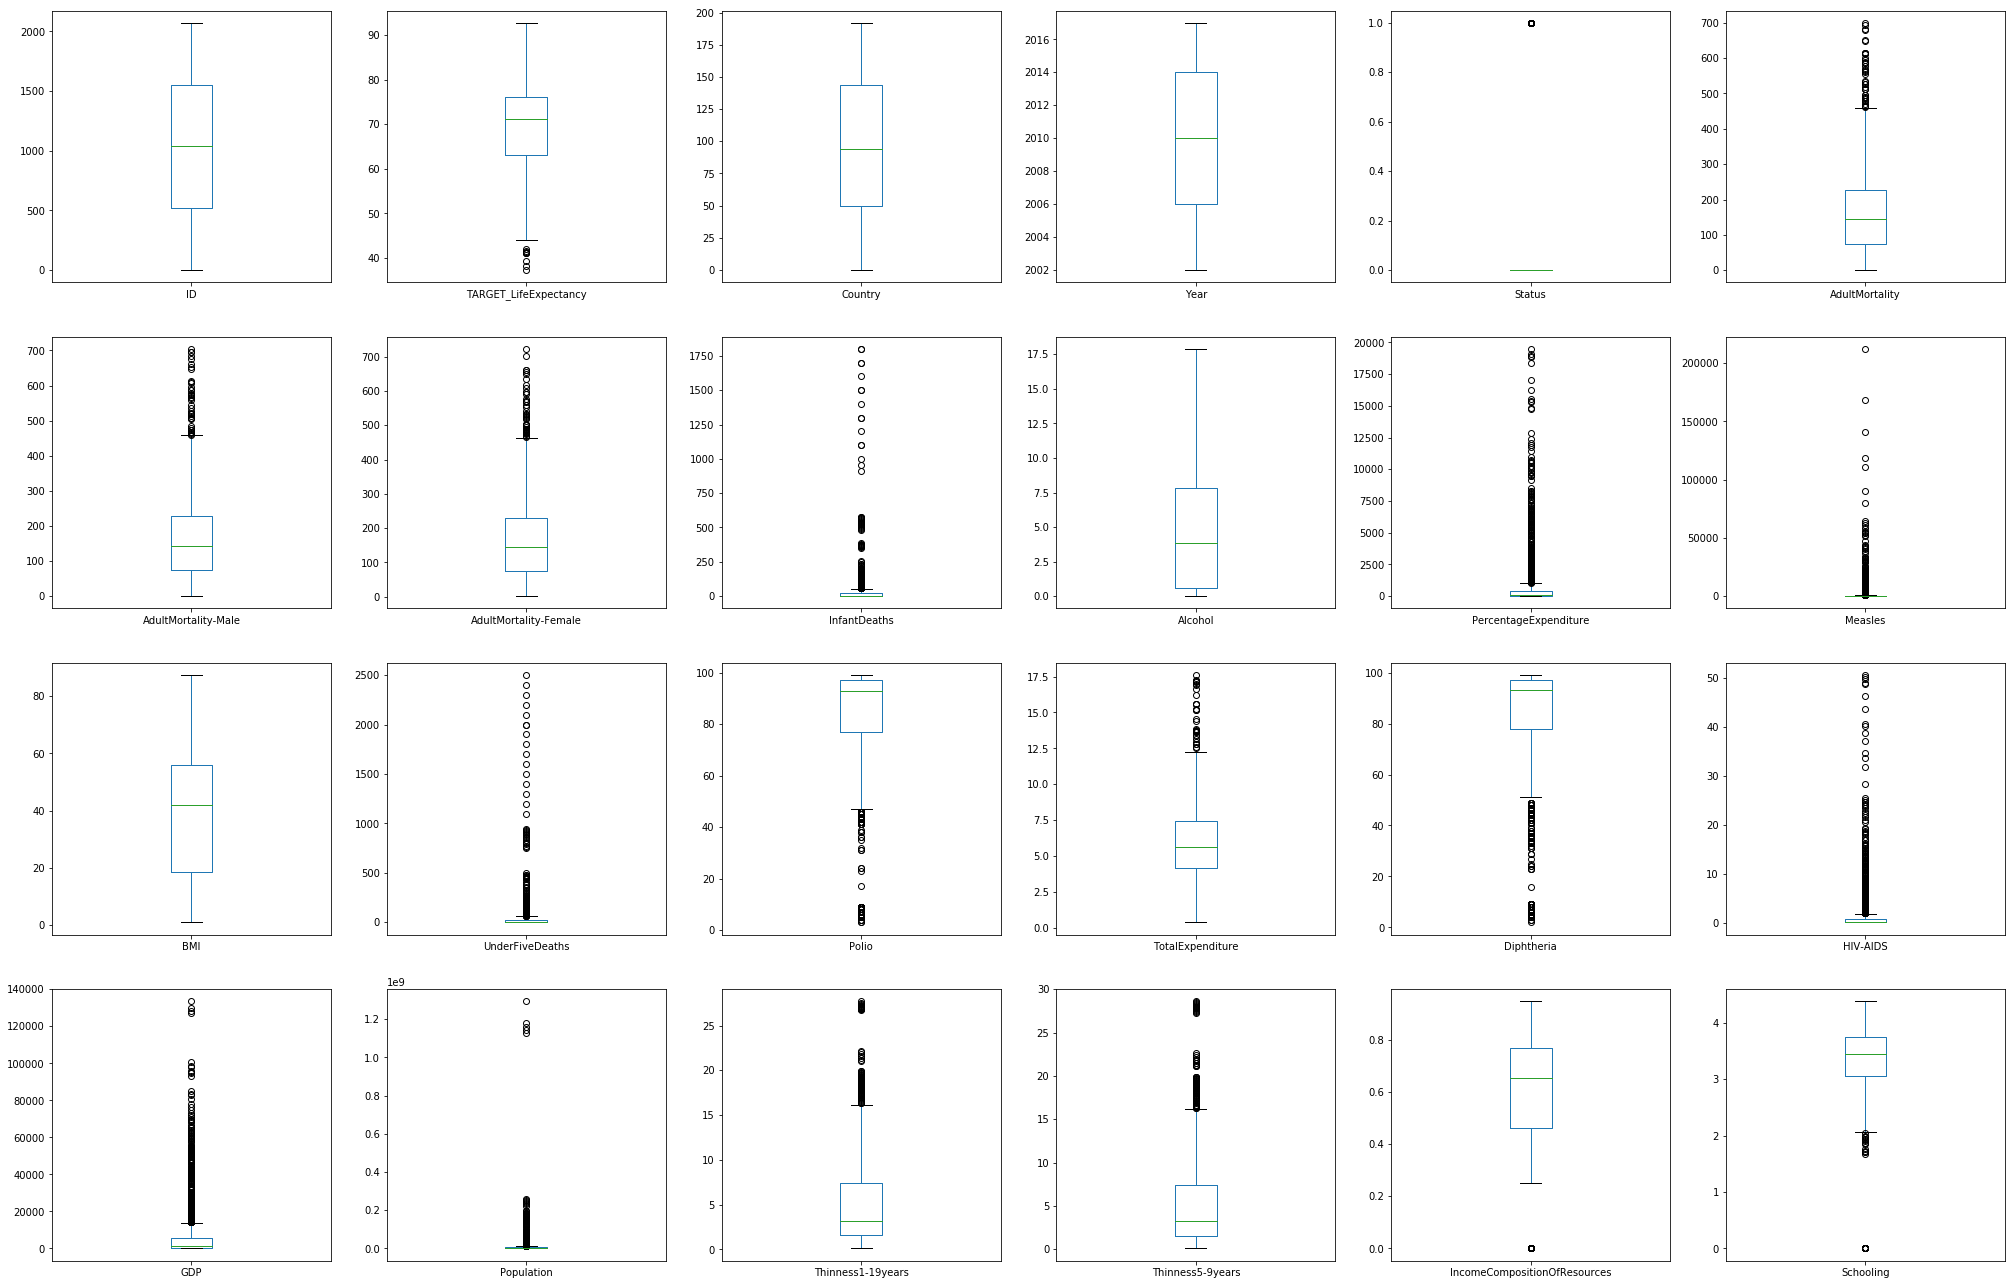

In [221]:
# Analysis of Data

# 1) The data has many outliers, and useless variables
#    that do not contribute to the target value (life expectancy)
# 2) Only a few variables within the dataset have been found to have a correlation with our target value: TARGET_LifeExpectancy

# Box Plot to find the outliers within the dataset
le_train_DF.plot(kind="box", subplots=True, layout=(6,6),
                sharex=False, sharey=False, figsize=(35,35))


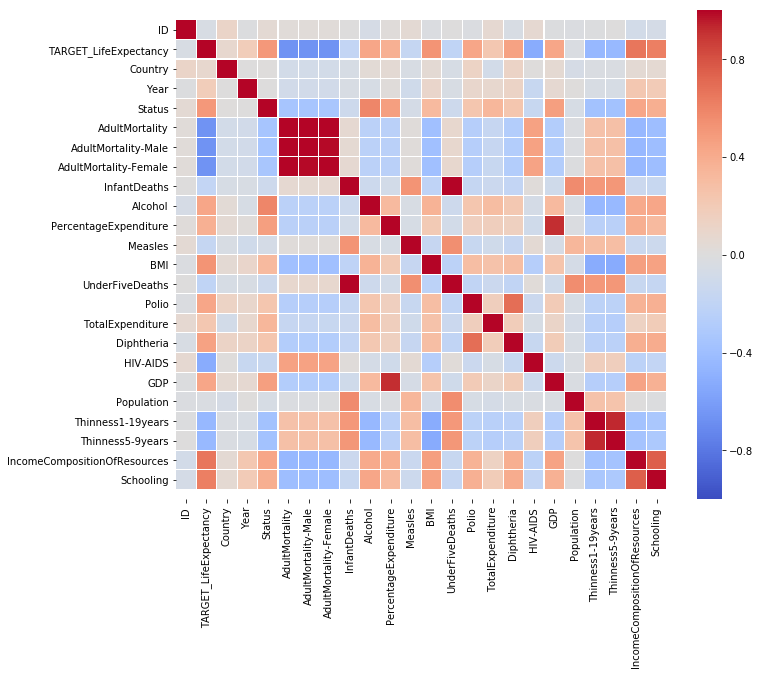

In [222]:
# Analysis- Correlation Heat Map
import seaborn as sns

correlations = le_train_DF.corr()

f, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(round(correlations,2), ax=ax, cmap="coolwarm", vmin=-1, vmax=1, fmt='.2f', linewidths=.05)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

In [223]:
# Normalise the data, using mean normalisation method
# Through the analysis, it has been observed on the box plots that there are significant outliers.
# Min Max Scaling does not handle outliers very well, so mean normalisation has been chosen instead
independent_scaler = preprocessing.StandardScaler()
target_scaler = preprocessing.StandardScaler()

# Set X as all independent variables (minus TARGET_LifeExpectancy)
X_train_DF = le_train_DF.iloc[:, 2:]
X_test_DF = le_test_DF.iloc[:, 1:]

# Set Y as dependent variable 'TARGET_LifeExpectancy'
Y_train_DF = le_train_DF['TARGET_LifeExpectancy']

# Convert into Array to manipulate
X_train_values = X_train_DF.values
Y_train_values = Y_train_DF.values
X_test_values = X_test_DF.values

X_train_values_scaled = independent_scaler.fit_transform(X_train_values)
Y_train_values_scaled = target_scaler.fit_transform(Y_train_values.reshape(-1, 1))
X_test_values_scaled = independent_scaler.fit_transform(X_test_values)

X_train = pd.DataFrame(X_train_values_scaled, columns=X_train_DF.columns)
Y_train = pd.DataFrame(Y_train_values_scaled)
X_test = pd.DataFrame(X_test_values_scaled, columns=X_test_DF.columns)

In [315]:
from sklearn import model_selection
number_splits = 10
kFold = model_selection.KFold(n_splits=number_splits, shuffle=True)

In [347]:
lRegPara = np.linspace(0.001,0.5,num=10)
lRegPara

array([0.001     , 0.05644444, 0.11188889, 0.16733333, 0.22277778,
       0.27822222, 0.33366667, 0.38911111, 0.44455556, 0.5       ])

In [446]:
#Split the train.csv into 80/20 split into a training set (80%) to testing set(20%)
# Training set will be cross validated, to tune the parameters of our model
# Test set will be used to test our tuning
from sklearn.model_selection import train_test_split

train_X, test_X = train_test_split(X_train, test_size=0.2, shuffle = False)
train_Y, test_Y = train_test_split(Y_train, test_size=0.2, shuffle = False)
# print(train_X)
# print(test_X.shape)
# print(train_Y.shape)
print(test_Y.shape)


(415, 1)


(1656, 22)
(1656, 22)


Text(0, 0.5, 'Average R-Score')

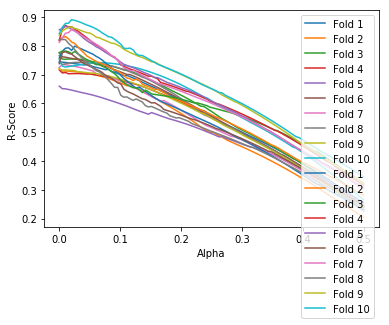

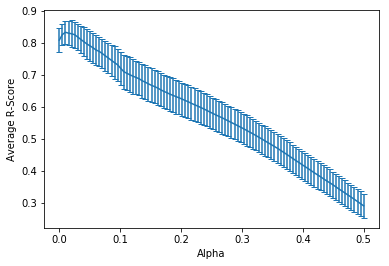

In [434]:
# Splitting Training and Validation set, via KFold Method
# To determine the best regression parameter is best, utilise cross validation to obtain the most effective one.
# Utilising Lasso Regression, although similar to Ridge Regression, it is better at eliminating use variables within our model
lRegPara = np.linspace(0.0001,0.5,num=100)
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
lResults = np.zeros((number_splits,len(lRegPara)))
best_r2_perDegree= []
alpha_results = {}
r2_results = []

for i in range(1, 3):
    polyFeat = PolynomialFeatures(degree=i, include_bias=True)
    nsplit = 0
    print(train_X.shape)
    for trainIndex, validIndex in kFold.split(train_X):

        # Get the training and validation data
        trainX = np.array(train_X.loc[trainIndex])
        trainY = np.array(train_Y.loc[trainIndex])
        validX = np.array(train_X.loc[validIndex])
        validY = np.array(train_Y.loc[validIndex])
#         trainX = np.array(X_train.loc[trainIndex])
#         trainY = np.array(Y_train.loc[trainIndex])
#         validX = np.array(X_train.loc[validIndex])
#         validY = np.array(Y_train.loc[validIndex])
        
#         print(trainX.shape)
#         print(trainY.shape)
#         print(validX.shape)
#         print(validY.shape)

#         print(trainX.shape)
#         print(trainY.shape)
#         print(validX.shape)
#         print(validY.shape)
        
        # This is where you're polynomial model is used!
        polyFitTrainX = polyFeat.fit_transform(trainX)
        polyFitValidX = polyFeat.fit_transform(validX)
        
        for j, regPara in enumerate(lRegPara):
            polyLassoReg = linear_model.Lasso(alpha=regPara, normalize=False, tol=0.1)
            model = polyLassoReg.fit(polyFitTrainX, trainY)
            predY = polyLassoReg.predict(polyFitValidX)
            r2 = r2_score(validY, predY, multioutput='raw_values')
            alpha_results[str(r2)] = (regPara)
            r2_results.append((r2))
            lResults[nsplit, j] = (r2)
        
        plt.plot(lRegPara, lResults[nsplit, :], label='Fold '+str(nsplit+1))
        nsplit = nsplit + 1
    best_r2_perDegree.append(np.median(r2_results))
    
plt.xlabel("Alpha")
plt.ylabel("R-Score")
plt.legend()

plt.figure()
plt.errorbar(lRegPara, np.mean(lResults,axis=0), yerr=np.std(lResults,axis=0),capsize=3)
plt.xlabel("Alpha")
plt.ylabel("Average R-Score")

In [411]:
# print(best_r2_perDegree)
# best_r2Score = np.around(np.median(best_r2_perDegree), decimals=8)
# print(best_r2_perDegree)
# # optimal_polyDegree = best_r2_perDegree.index(np.median(best_r2_perDegree)) + 1
# optimal_polyDegree = 2
# print(optimal_polyDegree)
# r2_results
# # optimal_regPara = alpha_results[str([best_r2Score])]
# optimal_regPara = alpha_results
# print(optimal_regPara)

In [439]:
polyFeat = PolynomialFeatures(degree=optimal_polyDegree, include_bias=True)
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

r2_score_avg = []
# This is where you're polynomial model is used!    

polyFitTrainX = polyFeat.fit_transform(train_X)
polyFitTestX = polyFeat.fit_transform(test_X)
polyLassoReg = linear_model.Lasso(alpha=optimal_regPara, normalize=False, tol=0.1)

print(polyFitTrainX.shape)
model = polyLassoReg.fit(polyFitTrainX, train_Y)
predY = model.predict(polyFitTestX)
mae = mean_absolute_error(test_Y, predY)
mse = mean_squared_error(test_Y, predY)
r2 = r2_score(test_Y, predY)
r2_score_avg.append(r2)

from IPython.display import FileLink, FileLinks

predY_DF = pd.DataFrame(predY)
predY_unscaled = target_scaler.inverse_transform(predY_DF)
predY_DF_unscaled = pd.DataFrame(predY_unscaled)
predY_DF_unscaled
csv = predY_DF_unscaled.to_csv('predictedY.csv', index=False)
r2_avg = np.mean(r2_score_avg)

(1656, 276)


In [436]:
predY_DF_unscaled
print(mae)
print(mse)
print(r2)

0.3399788499095362
0.21962751211906867
0.8020026476570778


In [470]:
polyFitTestX_n = polyFeat.fit_transform(X_test)
predY_n = model.predict(polyFitTestX_n)

predY_DF_n = pd.DataFrame(predY_n)
predY_unscaled = target_scaler.inverse_transform(predY_DF_n)
predY_DF_unscaled = pd.DataFrame(predY_unscaled)
predY_DF_unscaled
csv = predY_DF_unscaled.to_csv('predictedY.csv', index=False)

In [471]:
predY_DF_unscaled

,0
0,60.464748
1,58.740254
2,58.430799
3,58.287784
4,57.805784
5,56.916649
6,56.315795
7,56.337042
8,56.379052
9,54.335600
